# The End of JSON Validation Hell

## A Practical Guide to OpenAI's Structured Outputs

### _Data Tech Conference 2025_

Code and Slides at https://github.com/ericness/end-of-json-validation-hell

## Agenda

- Presenter Bio
- Problem Statement
- Demo: Extracting Structured Data using GPT Models
- Analyzing Problems
- Demo: Using OpenAI Structured Output
- Conclusion

## Eric Ness

### Principal Machine Learning Engineer @ C.H. Robinson

C.H. Robinson is a Fortune 250 supply chain broker headquarterd in Eden Prairie

Two LLM-Based Projects in Production
- Converting email orders to JSON requests for orders API
- Categorizing freight using national standard codes

LinkedIn: https://www.linkedin.com/in/ericnessdata/

## Extracting Data from Unstructured Input

- Many use cases need to extract structured data from unstructured input
- Could include emails, documents, images, audio and so forth
- Typically the output format is JSON

## Problems with Using Only Prompting

- Doesn't guarantee correct schema due to probabilistic nature of LLM output
- Even 99% accuracy on schema isn't sufficient for many production applications

In [6]:
from collections import defaultdict
import asyncio
from enum import StrEnum
import json
import math
import re

from IPython.display import display, HTML
from datasets import load_dataset
from openai import AsyncOpenAI, OpenAI
from pydantic import BaseModel, Field, ValidationError
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import nest_asyncio
import numpy as np
import pandas as pd

In [7]:
nest_asyncio.apply()

## Demo: Extracting Structured Data using GPT Models

- Use a HuggingFace dataset to demonstrate using a prompt-only approach to extracting data
- `SetFit/bbc-news` contains 2225 BBC news articles from 2004-2005
- Each article is labeled under one of five categories

In [8]:
dataset = load_dataset("SetFit/bbc-news")

train_df = pd.DataFrame(dataset["train"])
test_df = pd.DataFrame(dataset["test"])
combined_df = pd.concat([train_df, test_df])

print("Dataset Overview:")
print(f"Dataset size: {len(combined_df)}")
print("\nLabel distribution in training set:")
print(combined_df["label_text"].value_counts())

train_df["text_length"] = train_df["text"].str.len()
print(f"\nText length mean: {train_df['text_length'].mean():.2f}")

Dataset Overview:
Dataset size: 2225

Label distribution in training set:
label_text
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

Text length mean: 2288.95


In [9]:
sample_text = combined_df["text"].iloc[0]
display(
    HTML(
        f'<div style="white-space: pre-wrap; font-family: monospace;">{sample_text}</div>'
    )
)

In [16]:
class ArticleCategory(StrEnum):
    BUSINESS = "business"
    ENTERTAINMENT = "entertainment"
    POLITICS = "politics"
    SPORT = "sport"
    TECH = "tech"


class NamedEntityType(StrEnum):
    COMPANY = "company"
    COUNTRY = "country"
    LOCATION = "location"
    PERSON = "person"
    TEAM = "team"

In [17]:
class NamedEntity(BaseModel):
    name: str = Field(description="Name of the person, company, etc.")
    type: NamedEntityType = Field(description="Type of named entity")


class NewsArticle(BaseModel):
    title: str = Field(
        description="Appropriate headline for the news article"
    )
    category: ArticleCategory = Field(
        description="Category of news that the article belongs to"
    )
    mentioned_entities: list[NamedEntity] = Field(
        description="List of all named entities in the article",
        default_factory=list,
    )
    summary: str = Field(
        description="Brief summary of the article content."
    )
    length: int = Field(description="Length of the article in words.")

In [18]:
news_article_schema = NewsArticle.model_json_schema()
print(json.dumps(news_article_schema, indent=2))

{
  "$defs": {
    "ArticleCategory": {
      "enum": [
        "business",
        "entertainment",
        "politics",
        "sport",
        "tech"
      ],
      "title": "ArticleCategory",
      "type": "string"
    },
    "NamedEntity": {
      "properties": {
        "name": {
          "description": "Name of the person, company, etc.",
          "title": "Name",
          "type": "string"
        },
        "type": {
          "$ref": "#/$defs/NamedEntityType",
          "description": "Type of named entity"
        }
      },
      "required": [
        "name",
        "type"
      ],
      "title": "NamedEntity",
      "type": "object"
    },
    "NamedEntityType": {
      "enum": [
        "company",
        "country",
        "location",
        "person",
        "team"
      ],
      "title": "NamedEntityType",
      "type": "string"
    }
  },
  "properties": {
    "title": {
      "description": "Appropriate headline for the news article",
      "title": "Title",
    

In [14]:
EXTRACTION_PROMPT = """
Read the news article below and extract the information into a
JSON object. This is the schema you should use to extract the
data. It's provided in standard JSON Schema format.

```json
{news_article_schema}
```

Here is the news article to generate the JSON data for. The article
is surrounded by triple backticks.

```
{news_article}
```

Format your response as a JSON object surrounded by triple backticks
with the 'json' identifier like this:
```json
your JSON object here
```

Be sure to follow the provided schema exactly.
"""

## Run Evaluation

Run an evaluation for all models in `model_names`. The criteria for passing is if the output text can be parsed into a `NewsArticle` object. If the validation fails for any reason then the test fails. The contents of the `NewsArticle` object aren't evaluated.

If this notebook is being run in Github Codespaces, you'll need to set `OPENAI_API_KEY` as a codespace secret in user settings. If it's being run locally then you'll need to set the environment variable `OPENAI_API_KEY`.

In [ ]:
async def extract_article_data(
    article: str,
    model_name: str,
    client: AsyncOpenAI,
    semaphore: asyncio.Semaphore,
) -> bool:
    """Returns true if JSON is appropriately formatted"""

    formatted_prompt = EXTRACTION_PROMPT.format(
        news_article_schema=json.dumps(news_article_schema, indent=2),
        news_article=article,
    )

    async with semaphore:
        response = await client.responses.create(
            model=model_name,
            input=formatted_prompt,
            temperature=0.0,
        )
    extracted_json = response.output_text
    json_match = re.search(
        r"```json\s*(.*?)\s*```", extracted_json, re.DOTALL
    )

    if json_match:
        json_content = json_match.group(1).strip()

        try:
            parsed_json = json.loads(json_content)
            _ = NewsArticle.model_validate(parsed_json)
            return True
        except (json.JSONDecodeError, ValidationError) as e:
            return False
    else:
        return False

In [ ]:
openai_client = AsyncOpenAI()

ARTICLE_COUNT = 100
MAX_CONCURRENT_TASKS = 3
loop_semaphore = asyncio.Semaphore(MAX_CONCURRENT_TASKS)

success_count = 0
model_names = ["gpt-3.5-turbo", "gpt-4-turbo", "gpt-4o-mini"]

results = defaultdict(list)
for model_name in model_names:
    tasks = [
        extract_article_data(
            article, model_name, openai_client, loop_semaphore
        )
        for article in combined_df["text"][:ARTICLE_COUNT]
    ]

    for f in tqdm(asyncio.as_completed(tasks), total=len(tasks)):
        results[model_name].append(await f)

    success_count = sum(1 for result in results[model_name] if result)
    print(
        f"For {model_name} successfully validated {success_count} of {ARTICLE_COUNT} records"
    )

  0%|          | 0/100 [00:00<?, ?it/s]

For gpt-3.5-turbo successfully validated 84 of 100 records


  0%|          | 0/100 [00:00<?, ?it/s]

For gpt-4-turbo successfully validated 90 of 100 records


  0%|          | 0/100 [00:00<?, ?it/s]

For gpt-4o-mini successfully validated 69 of 100 records


# Display Results

In [ ]:
model_success_rates = {}
for model_name, results_list in results.items():
    success_count = sum(1 for result in results_list if result)
    success_rate = (success_count / len(results_list)) * 100
    model_success_rates[model_name] = success_rate

In [ ]:
models = list(results.keys())
success_rates = [model_success_rates[model] for model in models]

plt.figure(figsize=(10, 6))
bars = plt.bar(
    models, success_rates, color=["#5DA5DA", "#FAA43A", "#60BD68"]
)

plt.xlabel("Model")
plt.ylabel("Success Rate (%)")
plt.title("JSON Extraction Success Rate by Model")
plt.ylim(0, 100)

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

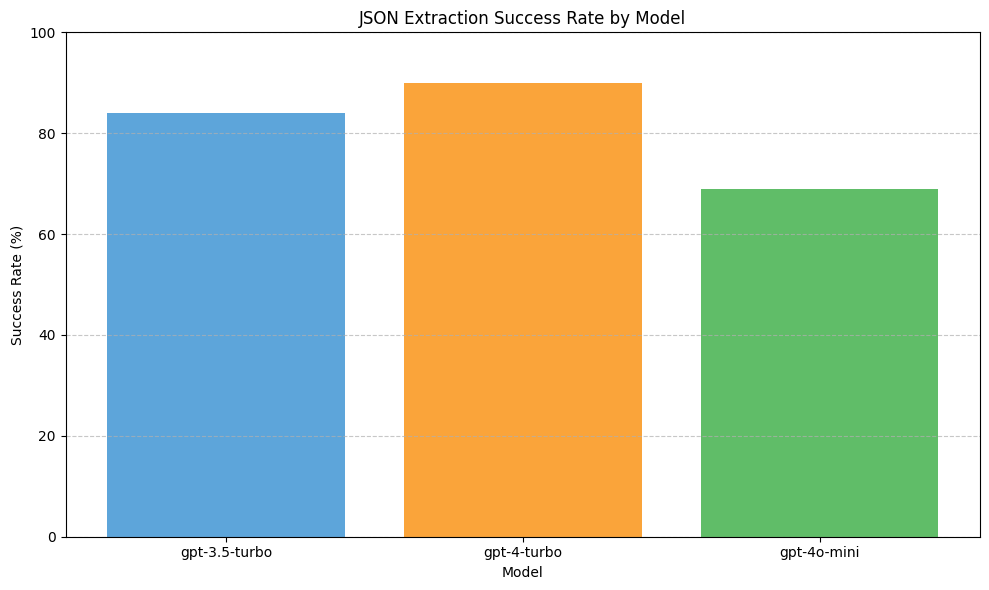

In [ ]:
plt.show()

## Analyze Logprobs


In [26]:
def visualize_json_with_heatmap(response):
    """
    Display the JSON output from a model response with a heatmap overlay based on token logprobs.
    Shows a tooltip with alternative tokens and probabilities on hover.
    """
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
    import numpy as np
    from IPython.display import display, HTML
    import json
    import re

    full_text = response.choices[0].message.content
    json_text = full_text

    try:
        parsed_json = json.loads(json_text)
        formatted_json = json.dumps(parsed_json, indent=2)
    except json.JSONDecodeError:
        formatted_json = json_text

    tokens = []
    probs = []
    top_logprobs_list = []

    for token_info in response.choices[0].logprobs.content:
        tokens.append(token_info.token)
        probs.append(np.exp(token_info.top_logprobs[0].logprob))
        # Prepare tooltip: token and probability for each top_logprob
        tooltip = [
            f"{tlp.token}: {np.exp(tlp.logprob):.3f}"
            for tlp in token_info.top_logprobs
        ]
        top_logprobs_list.append("\n".join(tooltip))

    reconstructed_text = "".join(tokens)
    json_pattern = re.escape(json_text)
    json_matches = re.finditer(
        json_pattern, reconstructed_text, re.DOTALL
    )

    try:
        match = next(json_matches)
        json_start = match.start()
        json_end = match.end()
    except StopIteration:
        cleaned_json = re.sub(r"\s+", "", json_text)
        cleaned_reconstructed = re.sub(r"\s+", "", reconstructed_text)
        json_start = cleaned_reconstructed.find(cleaned_json)
        if json_start == -1:
            json_start = 0
            json_end = len(reconstructed_text)
        else:
            json_end = json_start + len(cleaned_json)
            original_pos = 0
            cleaned_pos = 0
            mapped_start = 0
            for i, char in enumerate(reconstructed_text):
                if not char.isspace():
                    if cleaned_pos == json_start:
                        mapped_start = i
                        break
                    cleaned_pos += 1
                original_pos += 1
            json_start = mapped_start
            json_end = json_start + len(json_text)

    token_indices = []
    current_pos = 0
    for i, token in enumerate(tokens):
        next_pos = current_pos + len(token)
        if (current_pos >= json_start and current_pos < json_end) or (
            next_pos > json_start and current_pos < json_end
        ):
            token_indices.append(i)
        current_pos = next_pos
        if current_pos > json_end:
            break

    cmap = plt.colormaps["RdYlGn"]
    norm = mcolors.Normalize(vmin=0, vmax=1)

    html_parts = []
    html_parts.append(
        """
    <style>
    .json-token-tooltip {
        position: absolute;
        background: #222;
        color: #fff;
        padding: 6px 10px;
        border-radius: 6px;
        font-size: 13px;
        z-index: 1000;
        pointer-events: none;
        white-space: pre;
        box-shadow: 0 2px 8px rgba(0,0,0,0.3);
        display: none;
        max-width: 350px;
    }
    </style>
    <script>
    if (!window.jsonTokenTooltipHandlerAdded) {
        window.jsonTokenTooltipHandlerAdded = true;
        document.addEventListener('mouseover', function(e) {
            var target = e.target;
            if (target.classList.contains('json-token')) {
                var tooltip = document.getElementById('json-token-tooltip');
                if (!tooltip) {
                    tooltip = document.createElement('div');
                    tooltip.id = 'json-token-tooltip';
                    tooltip.className = 'json-token-tooltip';
                    document.body.appendChild(tooltip);
                }
                tooltip.innerText = target.getAttribute('data-tooltip');
                tooltip.style.display = 'block';
            }
        });
        document.addEventListener('mousemove', function(e) {
            var tooltip = document.getElementById('json-token-tooltip');
            if (tooltip && tooltip.style.display === 'block') {
                tooltip.style.left = (e.pageX + 15) + 'px';
                tooltip.style.top = (e.pageY + 10) + 'px';
            }
        });
        document.addEventListener('mouseout', function(e) {
            var target = e.target;
            if (target.classList.contains('json-token')) {
                var tooltip = document.getElementById('json-token-tooltip');
                if (tooltip) tooltip.style.display = 'none';
            }
        });
    }
    </script>
    """
    )

    html_parts.append(
        '<pre style="font-family: monospace; white-space: pre-wrap; line-height: 1.5;">'
    )

    if not token_indices:
        html_parts.append(f"<span>{formatted_json}</span>")
    else:
        for idx in token_indices:
            token = tokens[idx]
            prob = probs[idx]
            tooltip = top_logprobs_list[idx]
            rgba = cmap(norm(prob))
            rgb = f"rgb({int(rgba[0]*255)}, {int(rgba[1]*255)}, {int(rgba[2]*255)})"
            luminance = (
                0.299 * rgba[0] + 0.587 * rgba[1] + 0.114 * rgba[2]
            )
            text_color = "black" if luminance > 0.5 else "white"
            html_token = (
                token.replace("&", "&amp;")
                .replace("<", "&lt;")
                .replace(">", "&gt;")
                .replace("\n", "<br>")
            )
            html_parts.append(
                f'<span class="json-token" style="background-color: {rgb}; color: {text_color};" data-tooltip="{tooltip}">{html_token}</span>'
            )

    html_parts.append("</pre>")

    html_parts.append(
        '<div style="margin-top: 20px; font-family: sans-serif;">'
    )
    html_parts.append("<p><b>Token Probability Legend:</b></p>")
    html_parts.append(
        '<div style="display: flex; width: 300px; height: 30px;">'
    )
    for i in range(10):
        prob = i / 10
        rgba = cmap(norm(prob))
        rgb = f"rgb({int(rgba[0]*255)}, {int(rgba[1]*255)}, {int(rgba[2]*255)})"
        html_parts.append(
            f'<div style="flex: 1; height: 100%; background-color: {rgb};"></div>'
        )
    html_parts.append("</div>")
    html_parts.append(
        '<div style="display: flex; width: 300px; justify-content: space-between;">'
    )
    html_parts.append(
        "<span>0.0</span><span>0.5</span><span>1.0</span>"
    )
    html_parts.append("</div>")
    html_parts.append("</div>")

    display(HTML("".join(html_parts)))

In [27]:
def generate_and_visualize_json(article_idx=0):
    """Generate JSON for an article and visualize the output with heatmap"""
    client = OpenAI()
    article = combined_df["text"].iloc[article_idx]

    formatted_prompt = EXTRACTION_PROMPT.format(
        news_article_schema=json.dumps(news_article_schema, indent=2),
        news_article=article,
    )

    # Call the API with logprobs
    response = client.beta.chat.completions.parse(
        model="gpt-4o-mini",  # Or any other model you want to test
        messages=[{"role": "user", "content": formatted_prompt}],
        temperature=0.0,
        logprobs=True,
        top_logprobs=5,
    )

    visualize_json_with_heatmap(response)

    return response

In [28]:
response = generate_and_visualize_json(6)

In [30]:
response = generate_and_visualize_json(10)


## Create LLM Prompt

This prompt injects the JSON schema that was generated as well as a news article to analyze.

In [ ]:
STRUCTURED_EXTRACTION_PROMPT = """
Read the news article below and extract the information into a
JSON object. 

Here is the news article to generate the JSON data for. The article
is surrounded by triple backticks.

```
{news_article}
```

"""

## Run Evaluation

Run an evaluation for all models in `model_names`. The criteria for passing is if the output text can be parsed into a `NewsArticle` object.

If this notebook is being run in Github Codespaces, you'll need to set `OPENAI_API_KEY` as a codespace secret in user settings. If it's being run locally then you'll need to set the environment variable `OPENAI_API_KEY`.

In [ ]:
async def extract_article_data(
    article: str,
    model_name: str,
    client: AsyncOpenAI,
    semaphore: asyncio.Semaphore,
) -> bool:
    """Returns true if JSON is appropriately formatted"""

    formatted_prompt = STRUCTURED_EXTRACTION_PROMPT.format(
        news_article=article
    )

    async with semaphore:
        response = await client.beta.chat.completions.parse(
            model=model_name,
            messages=[{"role": "user", "content": formatted_prompt}],
            temperature=0.0,
            response_format=NewsArticle,
        )

        news_article = response.choices[0].message.parsed
        return isinstance(news_article, NewsArticle)

In [ ]:
openai_client = AsyncOpenAI()

ARTICLE_COUNT = 100
MAX_CONCURRENT_TASKS = 4
loop_semaphore = asyncio.Semaphore(MAX_CONCURRENT_TASKS)

success_count = 0
model_names = ["gpt-4o-mini"]
# model_names=["gpt-3.5-turbo", "gpt-4-turbo", "gpt-4o-mini"]

results = defaultdict(list)
for model_name in model_names:
    tasks = [
        extract_article_data(
            article, model_name, openai_client, loop_semaphore
        )
        for article in combined_df["text"][:ARTICLE_COUNT]
    ]

    for f in tqdm(asyncio.as_completed(tasks), total=len(tasks)):
        results[model_name].append(await f)

    success_count = sum(1 for result in results[model_name] if result)
    print(
        f"For {model_name} successfully validated {success_count} of {ARTICLE_COUNT} records"
    )

  0%|          | 0/100 [00:00<?, ?it/s]

For gpt-4o-mini successfully validated 100 of 100 records


## Display Results

In [ ]:
model_success_rates = {}
for model_name, results_list in results.items():
    success_count = sum(1 for result in results_list if result)
    success_rate = (success_count / len(results_list)) * 100
    model_success_rates[model_name] = success_rate

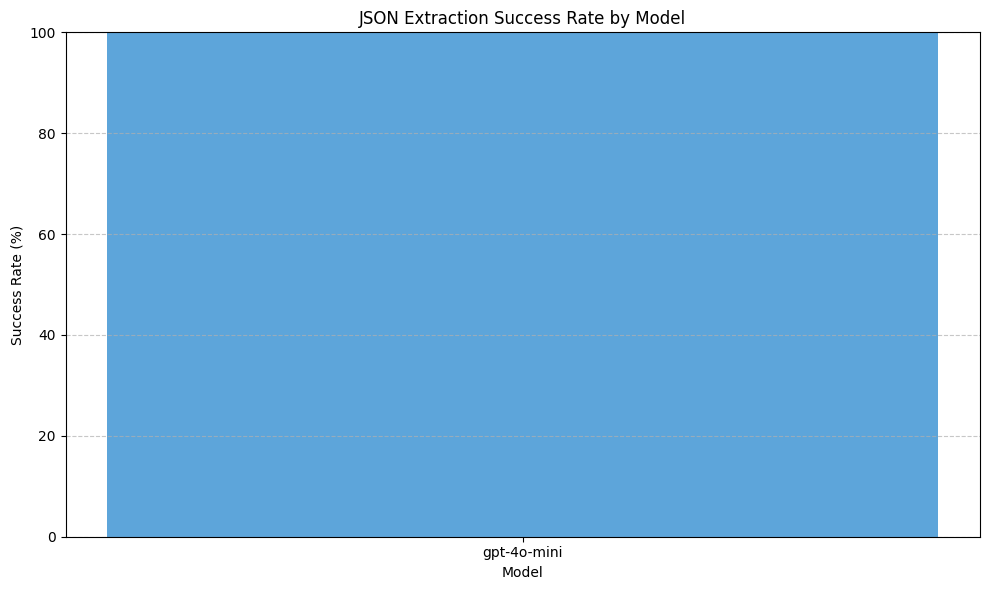

In [ ]:
models = list(results.keys())
success_rates = [model_success_rates[model] for model in models]

plt.figure(figsize=(10, 6))
bars = plt.bar(
    models, success_rates, color=["#5DA5DA", "#FAA43A", "#60BD68"]
)

plt.xlabel("Model")
plt.ylabel("Success Rate (%)")
plt.title("JSON Extraction Success Rate by Model")
plt.ylim(0, 100)

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
def generate_structured_and_visualize_json(article_idx=0):
    """Generate JSON for an article and visualize the output with heatmap"""
    from openai import OpenAI

    # Set up client
    client = OpenAI()
    article = combined_df["text"].iloc[article_idx]

    # Use the prompt with schema
    formatted_prompt = EXTRACTION_PROMPT.format(
        news_article_schema=json.dumps(news_article_schema, indent=2),
        news_article=article,
    )

    # Call the API with logprobs
    response = client.beta.chat.completions.parse(
        model="gpt-4o-mini",  # Or any other model you want to test
        messages=[{"role": "user", "content": formatted_prompt}],
        temperature=0.0,
        logprobs=True,
        top_logprobs=5,
        response_format=NewsArticle,
    )

    # Visualize the result
    visualize_json_with_heatmap(response)

    return response

In [31]:
generate_structured_and_visualize_json(10)

ParsedChatCompletion[NewsArticle](id='chatcmpl-BTBmIdDjrOWlvlJz5BcD9PGtd4M7f', choices=[ParsedChoice[NewsArticle](finish_reason='stop', index=0, logprobs=ChoiceLogprobs(content=[ChatCompletionTokenLogprob(token='{\n', bytes=[123, 10], logprob=-0.5241047143936157, top_logprobs=[TopLogprob(token='{\n', bytes=[123, 10], logprob=-0.5241047143936157), TopLogprob(token='{"', bytes=[123, 34], logprob=-0.8991047143936157), TopLogprob(token='\n', bytes=[10], logprob=-7.524104595184326), TopLogprob(token='{', bytes=[123], logprob=-9.336605072021484)]), ChatCompletionTokenLogprob(token=' ', bytes=[32], logprob=-2.868328920158092e-05, top_logprobs=[TopLogprob(token=' ', bytes=[32], logprob=-2.868328920158092e-05), TopLogprob(token='   ', bytes=[32, 32, 32], logprob=-10.625028610229492), TopLogprob(token='\t', bytes=[9], logprob=-12.625028610229492), TopLogprob(token='  ', bytes=[32, 32], logprob=-14.500028610229492), TopLogprob(token='"title', bytes=[34, 116, 105, 116, 108, 101], logprob=-14.50002